# **Product Image Classifier and Recommendation System**

## **Problem Statement**

E-commerce sites have thousands of listings everyday and at times, the users may not be correctly classifying their uploaded image or be using the wrong product depiction. Mismatch of product listing information will decrease the effectiveness of succssful transactions and also result in unnecessary resources being utilitzed to perform these corrections on a large scale. A product detection system would help to ensure the correct listing and categorization of products or to assist the user in classifying product types. To meet this need, an image classifer will be trained and developed to accurately identify the correct image labels with the use of convulated neural networks. Customized CNN architecture and fine-tuned VGG-16 models will be used to analyse classification effectiveness. The aim is to have a self-constructed network model within 5 percentage points of a tested award winning pre-trained model.

Also, in order to boost listings and sales, it would be desirable to have an image recommendation system, based on deep learning,to present product images which are visually similar to previous posting images viewed by the user. Making use of nearest neighbours, a model will also be developed to match closest resembling products images within a particular category.

## **Executive Summary**

This capstone project would be aimed at building an image classification model using convulated neural networks that will identify the following 4 categories of products: backpacks, clothing, footwear and watches. The source data to construct this model will be based on 20,000 images scraped from Amazon, the world's largest online retailer. Based on this, a recognition model will be used to correctly class a certain product image. Secondly, a recommendation system would be built to promote the closest matches based on a select product image.

Stakeholders will be the e-commerce companies and the user of the services themselves. It will help the company improve the effectiveness of potential transactions. It will also improve the user experience with more accuracy and also to avoid problems arising from wrongly identifying products. Often, users may want to source for similar looking items and a recommender would help to efficiently match a user's preferences to similar postings, giving rise to increased transactions and sales turnover.

The detailed solution to this would be to make use of unsupervised machine learning via neural networks in order to perform multi-classification of product categories. Dimensional clustering can also be used in order to match similar looking product images for the recommender system.

Metrics used to measure the performance would be accuracy using majority class and also compared to Imagenet pre-trained model performance, to be within 5 percentage points. Challenges foreseen would be lack of sufficient data, complex background noise or poor resolution images.


## <b>1. Data Collection</b>

Selenium and chrome webdriver is used to scrape the 4 categories in Amazon. The image formats are known to be fixed in size and hence will be saved as JPEG format. To ensure a sufficient quantity for testing and to account for possible discarding of ineligible datapoints, 5,000 images were saved from each class. They were extracted to the respective folders:
<ul>
    <li>Watch_Images</li>
    <li>Shirt_Images</li>
    <li>Footwear_Images</li>
    <li>Backpack_Images</li>
</ul>

The notebook for image web scraping can be found at <b>1_Image_Scrape.ipynb</b>

Infrastructure for running exploratory data analysis and modelling was utilizing Google Colaboratory's GPU & TPU Unit and hosted RAM of up to 35 GB. 

**Google Colab Initialization**

The execution and deployment of the neural networks processing will be performed on Google Colaboratory Pro - a hosted Jupyter notebook environment with data uploaded to Google Drive.

Inspect Colab Assign GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Aug  5 14:10:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Colab Memory Check

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 38.0 gigabytes of available RAM

You are using a high-RAM runtime!


<b>Drive Mounting</b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Import Libraries**

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
import requests
import random
from os import listdir
from random import shuffle 
from tqdm import tqdm
from multiprocessing import Pool
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import layers
from keras.models import Model,Sequential,load_model,model_from_json
from keras.layers import Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, Dropout, Flatten, Dense
from keras.utils import np_utils, to_categorical

import tensorflow as tf
from tensorflow.keras import layers, models, Model, applications
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from matplotlib import image,cm
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Load Images from Directory**

In [3]:
#Unzip the data into the current working directory
!unzip -q "/content/drive/My Drive/Colab Notebooks/Shirt_Images.zip"
!unzip -q "/content/drive/My Drive/Colab Notebooks/Footwear_Images.zip"
!unzip -q "/content/drive/My Drive/Colab Notebooks/Watch_Images.zip"
!unzip -q "/content/drive/My Drive/Colab Notebooks/Backpack_Images.zip"

In [4]:
#Move these folders into single folder names as Dataset
!mkdir Dataset
!mv Shirt_Images Dataset
!mv Footwear_Images Dataset
!mv Watch_Images Dataset
!mv Backpack_Images Dataset

In [5]:
ls Dataset/

Backpack_Images/  Footwear_Images/  Shirt_Images/  Watch_Images/


In [6]:
path = "Dataset/" 
image_size = 128
channels = 3
types = ["Shirt_Images","Footwear_Images","Watch_Images","Backpack_Images"]

total_images = 0
for root, dirs, files in os.walk(path):
    total_images += len(files)

#Initialize the containers for storing the image and labels
labels = np.empty(total_images)
images = np.empty((total_images,image_size,image_size,channels)) # Container for colored images
heights = np.empty(total_images)
widths = np.empty(total_images) 
count = 0

for i in types:
    print("Reading the  data for: ", i)
    for p in os.listdir(path + i):
        image = cv2.imread(path + i + '/' + p)
        heights[count] = image.shape[0]
        widths[count] = image.shape[1]
        image = cv2.resize(image, (image_size, image_size))
        image = image/255.0
        images[count] = image
        labels[count] = types.index(i)
        
        count+=1

print("\nNumber of Dataset {} and Number of Labels {}".format(len(images),len(np.unique(labels)))) 

Reading the  data for:  Shirt_Images
Reading the  data for:  Footwear_Images
Reading the  data for:  Watch_Images
Reading the  data for:  Backpack_Images

Number of Dataset 20000 and Number of Labels 4


## <b>2. Exploratory Data Analysis</b>

### <b>2.1 Visual Inspection of Sample</b>

A random sample of images are inspected to check that the correct images are present and to verify that the label classification matches. The sampling reflects that all the product classes images are present, visually complete and distinguishable without much distortion. In other words, these images have sufficient feature information in order to be passed into the learning model.

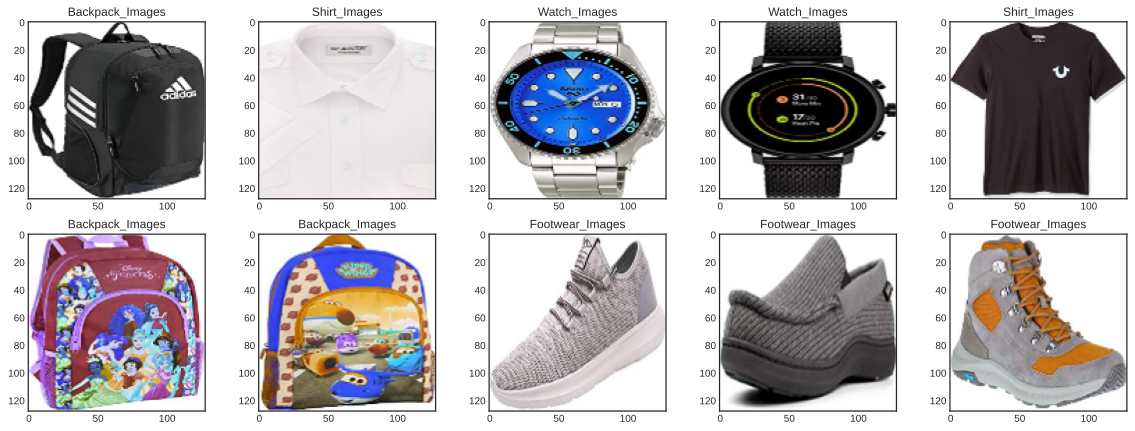

In [ ]:
index = np.random.randint(0, len(images) - 1, size= 10)
plt.figure(figsize=(20,15))
for i, index in enumerate(index, 1):
    img = images[index]
    type_ind = labels[index]
    title = types[int(type_ind)]
    plt.subplot(4, 5, i)
    plt.title(title)
    plt.imshow(img)

A preliminary visual inspections shows that there minimal image noise due from type inconsistency. There are images that are missclassified and out-of-category but these only comprise of a miniscule number of the data set. 
<ul>
<li>The watch images are mostly consistent and of similar representation. Out of category images like accessories exist but are minimal in number.</li>
<li>The shoe images are mostly clean, unique and of similar representation without much internal image noise. However, there is a mix of variations such as slippers, boots and sandals.This category also tends to contain images which have repeated multiple objects.</li>
<li>The shirt category has a mix image representation. There are variations such as long & short sleeves, hoodies, vests, singlets and also human representation for some of the images.</li>
<li>The backpack category has a very diverse mix of design and probably one with the most variations such as sling bags, laptop bags, haversacks, multi-product images and also human representation for some of the images.</li>
</ul>

**Dimension Distribution**

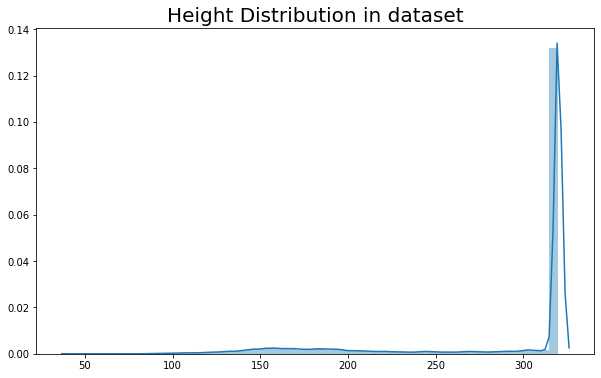

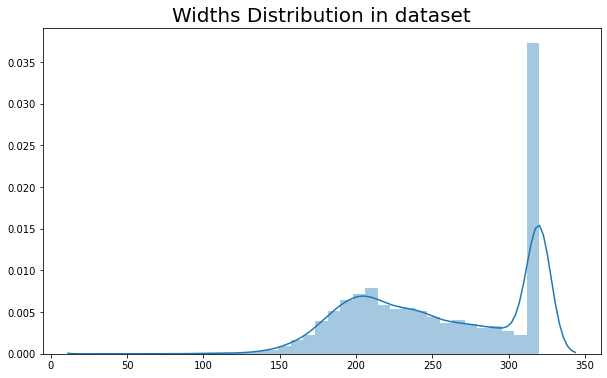

In [ ]:
# Image Height Distribution
plt.figure(figsize=(10,6))
sns.distplot(heights)
plt.title("Height Distribution in dataset", fontsize=20)
plt.show()

# Image Width Distribution
plt.figure(figsize=(10,6))
sns.distplot(widths)
plt.title("Widths Distribution in dataset", fontsize=20)
plt.show()

Next, to get a sense of how we could perform a general image sizing representative of all image classes for the purpose of convulational input, we analyze the mean heights and widths across all datapoints.

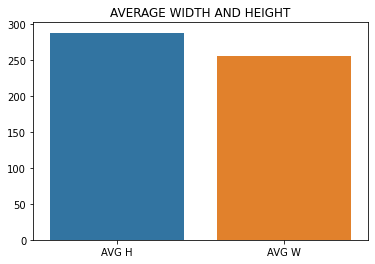

In [ ]:
average_height = np.mean(heights)
average_width = np.mean(widths)
sns.barplot(x=['AVG H','AVG W'],y=[average_height,average_width])
plt.title("AVERAGE WIDTH AND HEIGHT")
plt.show()

It can observed that in the frequency distribution, a majority of the images come at slightly more than 300 pixels for both the height and width with the smallest pixel counts being just over a 100 pixels. These can be due to the product nature in itself. The lower pixel width distributions can be attributed mostly the watch and backpack images, which typically are captured in an upright position with the the widths spanning slightly more than the watch face and backpack base width. The lower pixel height distributions mostly come from the footwear section where images are generally limited mostly to the heel size and are negligible as it is only one of the 4 products having this feature.

For the average width height & width, we can observe that there is not much distortion when choosing to fix equal dimension lengths.

### **2.2 Image Augmentation**

The use of image augmentation allows a diversity of image selections when training the models in order to boost the performance of deep networks. Image augmentation will create training images in a multitude of representations such as axial flips, rotations, shears or shifts etc. 

Augmented images can be produced through the ImageDataGenerator from the Keras API library and integrated with the neural networks.

Below, we attempt to examine some forms of augmentation parameter visually.

**Select a random image to perform augmentation**

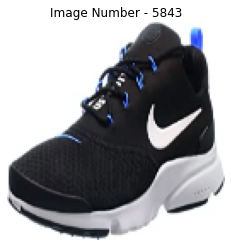

In [ ]:
index = np.random.randint(0, len(images))
test_image = images[index]
plt.title("Image Number - {}".format(index))
plt.axis('off') 
plt.imshow(test_image);

**Initialize Image Data Generator**

A wide range of properties will be incorporated and several sample visuals of the augmented versions of these propoerties will be generated to have a visual understanding of how these change effects look like.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=30,# randomly rotate images
        shear_range=0.1, # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        zoom_range=0.2, # randomly zoom into image
        width_shift_range=0.1, # randomly shift images horizontally
        height_shift_range=0.1, # randomly shift images vertically
        horizontal_flip=0.5, # randomly perform a horizontal flip
        vertical_flip= False, # randomly perform a horizontal flip
        fill_mode='nearest')

In [ ]:
from numpy import expand_dims

augmented_image = expand_dims(test_image, 0)
datagen.fit(augmented_image)

**Plot visual representation of augmented images**

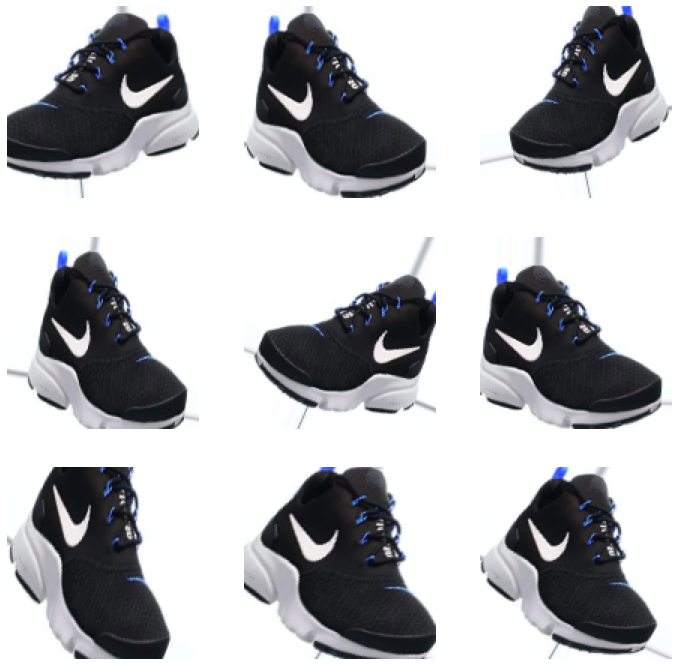

In [ ]:
i=0
plt.figure(figsize=(12, 12))
for img_batch in datagen.flow(augmented_image):
    for img in img_batch:
        plt.subplot(330 + 1 + i)
        plt.axis('off') 
        plt.imshow(img)
        i=i+1    
    if i >= 9:
        break

Above, we can observe how the image manipulations can expose the training model to changes in properties such as spatial orientation and partial feature views based just on one image. This allows the model to not be overfitted on just one stereotypical representation of the product. Subsequently, augmentation will be incorporated into the model fitting.

### **2.3 PCA Visualization**

PCA is a dimension reduction algoritum useful for reducing higher dimensional information into a graph. PCA visualization will be used to gain some insight into the relationship between the 128 x 128 pixel images using a projection of lesser dimensional count to 3 dimensions.

**Flattening the images**

In [ ]:
images_flattened = images.reshape(images.shape[0],-1)

**PCA on Coloured Images**

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(images_flattened)

In [ ]:
pca_result.shape

(20000, 3)

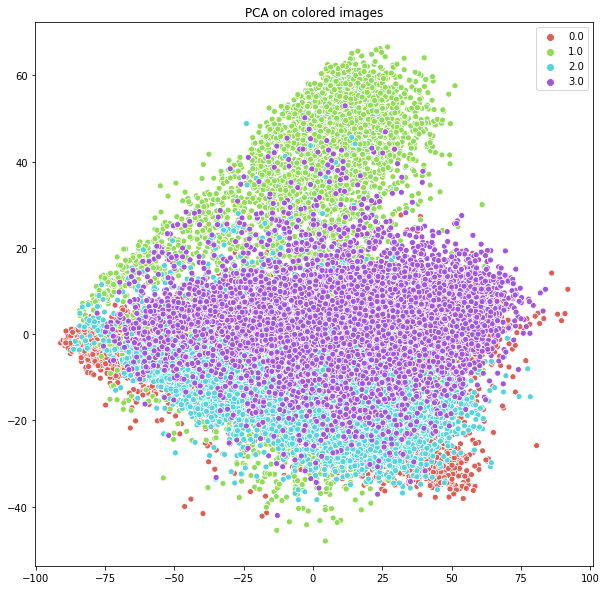

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1],hue=labels,palette=sns.color_palette("hls", 4),legend="full")
plt.title("PCA on colored images")
plt.show()

PCA plot attempts to represent the 4 classes into different clustered groups of similar points, which the points being a projection along directions with the largest variance. There is a lot of overlapping between the groups and definitely not suitable for a clustering algoritm to identify and pick out the individual clusters.

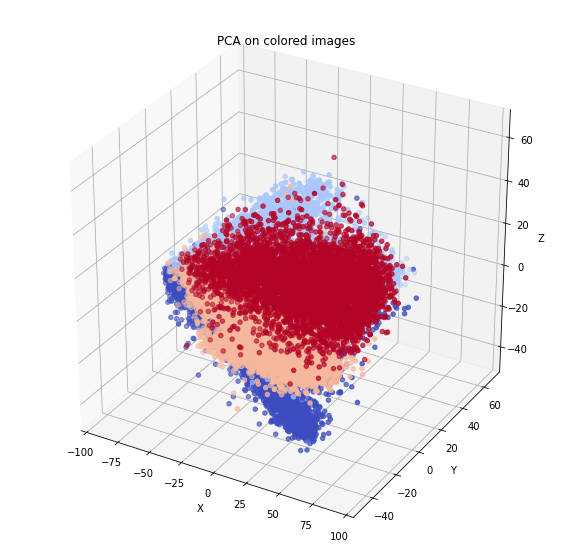

In [ ]:
ax = plt.figure(figsize=(12,12)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=labels,
    cmap = cm.coolwarm
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("PCA on colored images")
plt.show()

We can observe form the above 2 plots that represent the optimal stretch and rotation of higher dimensional space into 2-3 dimensions in an unsupervised manner. PCA chooses the optimal low dimensional functions such that a few of them can reconstruct the bulk of the dataset elements.PCA seems to be good for dimensional reduction but it cannot represent complex relationship between features.

In [ ]:
pca2 = PCA().fit(images_flattened)
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Explained Variance Ratio");

We can see from the plot of explained variance ratio to estimate how many components are required to describe the data. It is observed from the curve that approximately the first 100-200 components is sufficient to describe close to 80% of the variance.

### **2.4 t-SNE Clustering Visualization**

t-SNE is a popular tool for visualizing high-dimensional data and can produce 2D maps from data with multiple dimensions. Using a tunable parameter of perplexity, t-SNE makes a guess about the number of close neighbours each point has, which typical ranges between 5-50. The default perplexity is 30 and learning rate at 200, using 1,000 iterations. It starts by calculating the similarity probability of points in high dimensional space and it's corresponding similarities in low dimensional space. It then attempts to minimize the differences between conditional probabilities for better representation of data points in lower dimensional space.

In [ ]:
tsne = TSNE(n_components=2).fit_transform(images_flattened)

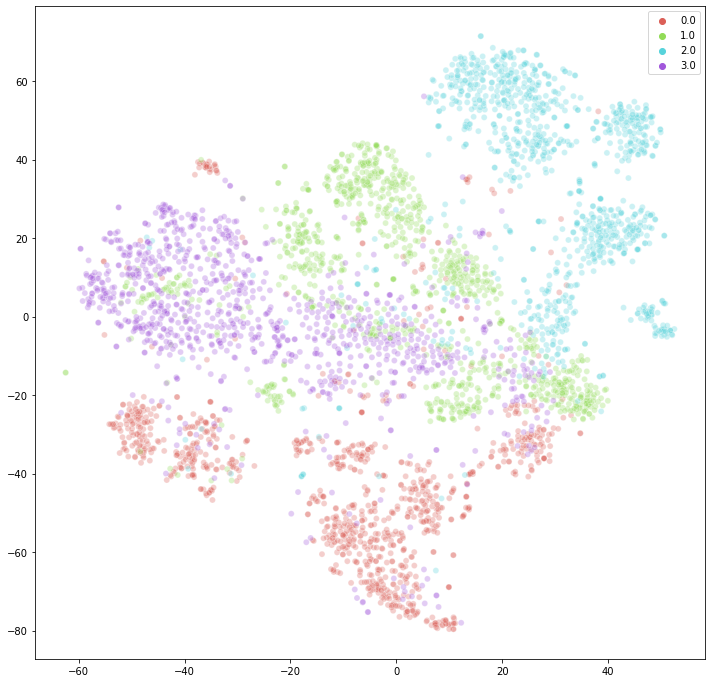

In [ ]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    x=tsne[:,0], y=tsne[:,1],
    hue=labels,
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)
plt.show()

Using t-SNE, it is observed that this is a significant improvement over PCA and that the individual clusters have more distinct demarcation boundaries that show segregation from right to left. The use of a clustering algorithm would be able to pinpoint unique clusters.

## **3. Modeling**

For the purposes of this project,the one network will be self-constructed and it's predictions will be compared against a keras library model network architecture to test the concept of transfer learning. The chosen keras model would be VGG-16 (Top-1 Accuracy - 0.713 , Depth 23, Size 528 MB)

The following network models will be evaluated:

*  Self-Constructed Model
*  Pre-Trained VGG-16 Model (Transfer Learning)

In the self-constructed model, the hyperparameters that will be experimented with include the network structure, epoch run and optimizers etc. Model weights will be saved to HD5 format. The final combination consistsof two convolutional blocks of depths 64 and 128 respectively using maximum pooling which is then passed through a final dense layer of a 1,000 nodes using softmax. Dropout is used at each interval with adam used as the optimizer. 

### **3.1 Splitting the Dataset for Training & Testing**

In [8]:
labels_categorical = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, shuffle=True, test_size=0.2, random_state=42)
print("X Train shape:", X_train.shape)
print("X Test shape:", X_test.shape)
print("Y Train shape:", y_train.shape)
print("Y Test shape:", y_test.shape)

X Train shape: (16000, 128, 128, 3)
X Test shape: (4000, 128, 128, 3)
Y Train shape: (16000, 4)
Y Test shape: (4000, 4)


In [ ]:
import joblib
filename = 'xtrain.sav'
joblib.dump(X_train.filename)

**Inspect Image Shuffling**

In [ ]:
print(y_test[11])
print(y_test[14])
print(y_test[22])
print(y_test[43])

[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[1. 0. 0. 0.]


Image set is confirmed to be randomized.

### **3.2 Baseline**

**Derive Majority Class in Train Set**

In [ ]:
class_frequency = pd.DataFrame({'Shirt': y_train[:, 0], 'Footwear': y_train[:, 1],'Watch': y_train[:, 2],'Backpack': y_train[:, 3]})
class_frequency.head()

,Shirt,Footwear,Watch,Backpack
0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [ ]:
class_frequency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Shirt     16000 non-null  float32
 1   Footwear  16000 non-null  float32
 2   Watch     16000 non-null  float32
 3   Backpack  16000 non-null  float32
dtypes: float32(4)
memory usage: 250.1 KB


In [ ]:
S_Total = class_frequency['Shirt'].sum()
print ("Total number of shirts:{}".format(S_Total))

F_Total = class_frequency['Footwear'].sum()
print ("Total number of footwear:{}".format(F_Total))

W_Total = class_frequency['Watch'].sum()
print ("Total number of watches:{}".format(W_Total))

B_Total = class_frequency['Backpack'].sum()
print ("Total number of backpacks:{}".format(B_Total))

Total number of shirts:4005.0
Total number of footwear:3976.0
Total number of watches:3996.0
Total number of backpacks:4023.0


**Set Baseline**

Since the number of backpacks is the biggest at 4,023 in the train set, the baseline accuracy score will be set at 25.1%

### **3.3 Model 1 (Custom Network)**

**Create Network Structure**

In [ ]:
# Create initial model
cnn_model = Sequential()

# Add the model layers

# The initial input layer is based off the pixel dimension chosen of 128 x 128 with a depth of 3.
# 64 filter nodes will be used for the first layer
# Due to the limited image sizing, a kernel size of 3 (common standard) has been chosen with a default stride of 1 
# Relu activation will be used

cnn_model.add(Conv2D(filters = 64,             # number of filters
                     kernel_size = (3,3),      # height/width of filter
                     activation='relu',        # activation function 
                     input_shape=(128,128,3))) # shape of input (image)

# To reduce any overfitting in the first layer, a small number of nodes will be dropped
cnn_model.add(Dropout(rate = 0.1))

# Pooling layer will be enforced to reduce the dimensions
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Second layer is added
cnn_model.add(Conv2D(filters= 128, kernel_size= (3,3),activation="relu"))
cnn_model.add(Dropout(rate = 0.2))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Node array converted to vertical configuration
cnn_model.add(Flatten())

# Add fully connected layer
cnn_model.add(Dense(1000, activation='relu'))
cnn_model.add(Dropout(rate = 0.5))

# Final layer for output for the 4 classes
cnn_model.add(Dense(4, activation='softmax'))

# Compile model using adam optimizer. Categorical is chosen due to multi-class prediction
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0

**Train the Model**

In [ ]:
EPOCHS = 50
BS = 128

# Fit model on training data.
history = cnn_model.fit(datagen.flow(X_train, y_train,batch_size=BS),
                                  validation_data=(X_test, y_test),
                                  steps_per_epoch=np.ceil(len(X_train)/BS),
                                  epochs=EPOCHS,
                                  verbose=1)

Epoch 1/50
125/125 [==============================] - 154s 1s/step - loss: 1.6551 - accuracy: 0.6372 - val_loss: 0.4560 - val_accuracy: 0.8493
Epoch 2/50
125/125 [==============================] - 153s 1s/step - loss: 0.5890 - accuracy: 0.7894 - val_loss: 0.3782 - val_accuracy: 0.8720
Epoch 3/50
125/125 [==============================] - 157s 1s/step - loss: 0.4743 - accuracy: 0.8312 - val_loss: 0.3545 - val_accuracy: 0.8780
Epoch 4/50
125/125 [==============================] - 155s 1s/step - loss: 0.4188 - accuracy: 0.8481 - val_loss: 0.3354 - val_accuracy: 0.8863
Epoch 5/50
125/125 [==============================] - 155s 1s/step - loss: 0.3741 - accuracy: 0.8674 - val_loss: 0.2876 - val_accuracy: 0.9050
Epoch 6/50
125/125 [==============================] - 154s 1s/step - loss: 0.3396 - accuracy: 0.8791 - val_loss: 0.2345 - val_accuracy: 0.9240
Epoch 7/50
125/125 [==============================] - 154s 1s/step - loss: 0.3157 - accuracy: 0.8864 - val_loss: 0.2171 - val_accuracy: 0.9258

**Accuracy and Loss Plots**

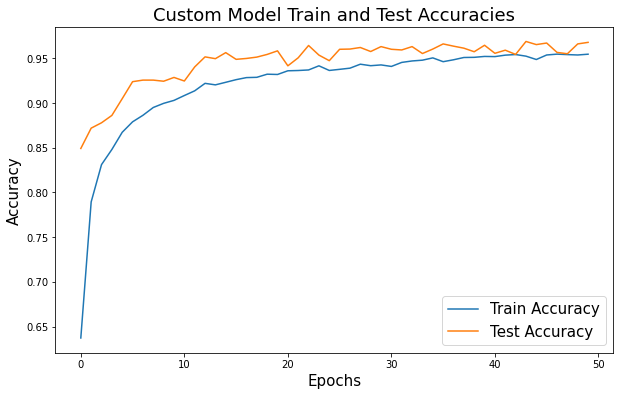

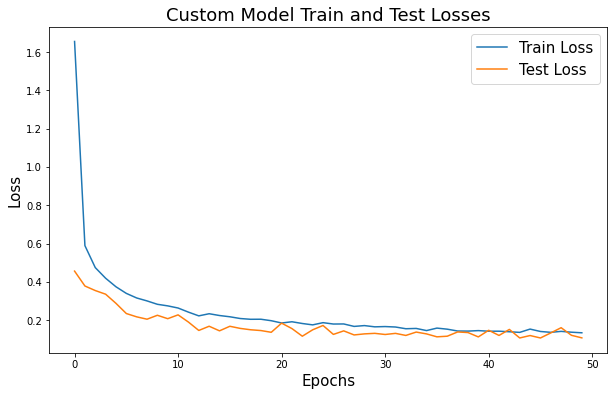

In [ ]:
EPOCHS = 50

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, EPOCHS), history.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, EPOCHS), history.history["val_accuracy"], label="Test Accuracy")
plt.title("Custom Model Train and Test Accuracies", fontsize = 18)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend(loc="lower right", fontsize = 15)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="Test Loss")
plt.title("Custom Model Train and Test Losses", fontsize = 18)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend(loc="upper right", fontsize = 15)
plt.show()

In [ ]:
# Evaluate model on test data.
cnn_score = cnn_model.evaluate(X_test,
                               y_test,
                               verbose=1)

cnn_labels = cnn_model.metrics_names

125/125 [==============================] - 6s 51ms/step - loss: 0.1074 - accuracy: 0.9680


In [ ]:
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')

CNN loss  : 0.10738877207040787
CNN accuracy   : 0.9679999947547913


After several rounds of calibrations and running the model over 50 epochs, a 97% overall accuracy was achieved with the major inflection point being around 10 epochs. The result generally seems to be well-fitted and the overall validation accuracy appears higher than the train accuracy at the early stages before gradual convergence.. The opposite behavior is also observed for the train-test loss. This could be due to the dropout technique used in most of the convolution blocks and layers that offsets potential overfitting. 

In [ ]:
cnn_pred = cnn_model.predict(X_test)
cnn_pred_classes = np.argmax(cnn_pred,axis = 1) 
cnn_true = np.argmax(y_test,axis = 1) 
cnn_confusion_mtx = confusion_matrix(cnn_true, cnn_pred_classes) 

In [ ]:
print(classification_report(cnn_true, cnn_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       995
           1       0.99      0.96      0.98      1024
           2       0.98      0.96      0.97      1004
           3       0.94      0.97      0.96       977

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



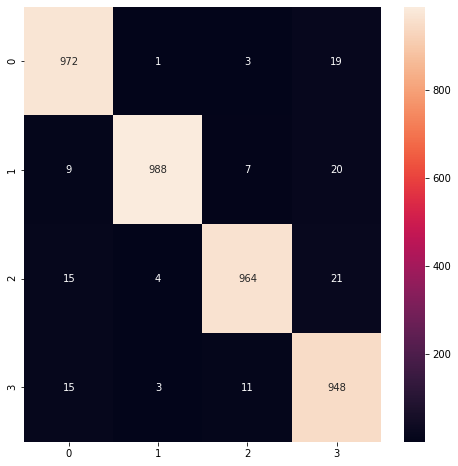

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(cnn_confusion_mtx, annot=True, fmt="d");

**Save the weights using HD5 JSON format**

In [ ]:
cnn_model.save('cnn_trained_model.h5')

In [ ]:
# Serialize model to JSON
model_json = cnn_model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HD5
cnn_model.save_weights("cnn_model.h5")
print("HD5 formatting complete.")

HD5 formatting complete.


**Convulation Layer Visualization**

In [ ]:
for layer in cnn_model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_1 (3, 3, 3, 64)
conv2d_2 (3, 3, 64, 128)


In [ ]:
cnn_layer_outputs = [layer.output for layer in cnn_model.layers if 'conv' in layer.name]
cnn_activation_model = Model(inputs=cnn_model.input, outputs=cnn_layer_outputs)
cnn_activations = cnn_activation_model.predict(images[12600].reshape(1,image_size,image_size,3))

In [ ]:
len(cnn_activations)

2

**Display 1st Convolutional Block**

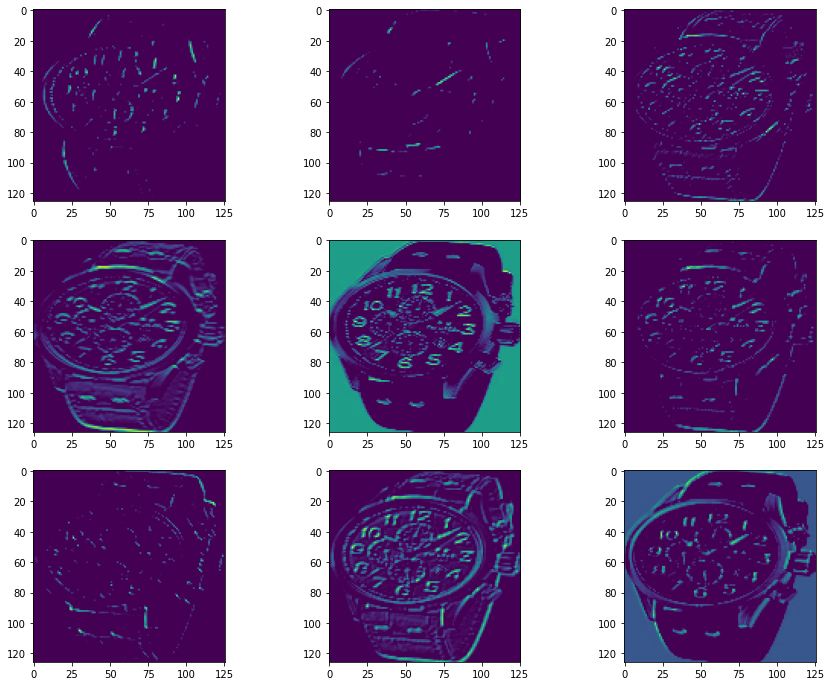

In [ ]:
activation = cnn_activations[0]
idx=0
row_size = 3
col_size = 3
fig, ax = plt.subplots(row_size, col_size, figsize=(15,12))
for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, idx])
            idx += 1


The first convolution block appears to be highlighting and activating different parts of the image and also background detection. This seems to be prevalent for starting layers that seek to identify lower level features such as edges and corners, hence making these features more visible.

**Display 2nd Convolutional Block**

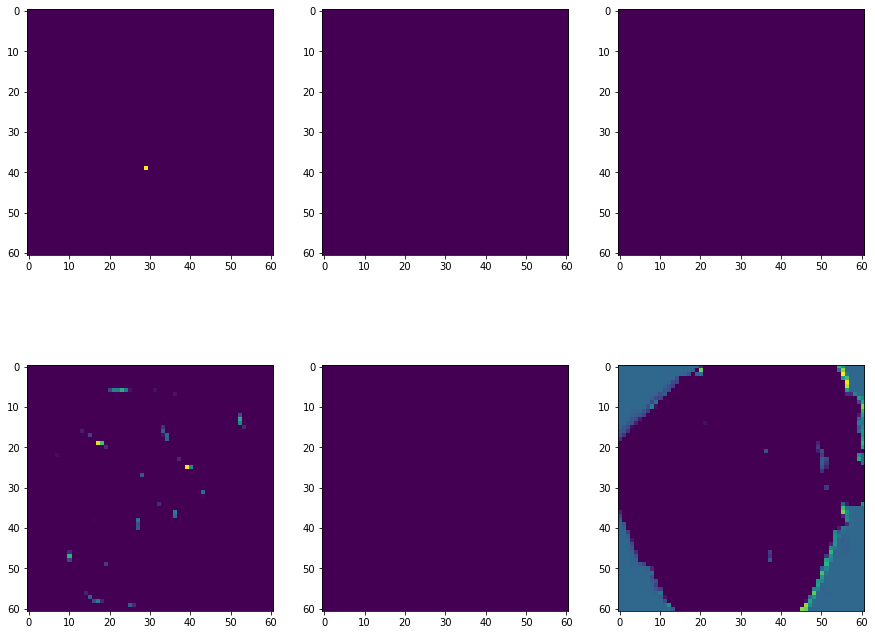

In [ ]:
activation = cnn_activations[1]
idx=0
row_size = 2
col_size = 3
fig, ax = plt.subplots(row_size, col_size, figsize=(15,12))
for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, idx])
            idx += 1

In the second block, the patterns captured by the convolutional kernel become more sparse and it is likely for blank filters to appear because such patterns might not even exist in the image to be captured. Hence in the second layer, we can see that more finer details are attempted to be resolved.

### **3.4 Model 2 (VGG-16 Model)**

A VGG-16 model with Imagenet weights will be tested to see how the custom network performs in comparison to one of leading trained networks in the industry. The VGG-16 CNN architecture is a reknown image recognition algoritm (ILSVRC 2014 Winner) for image classification and consists of 16 weighted layers, primarily with 3x3 filters, which can achieve up to 92.7% accuracy in top-5 test of ImageNet. It is a popular CNN model commonly used for feature extraction. 

Some modifications will be made to this network however. As it accepts an original input dimension of 224 x 224, modifications will be made to the model to accept tensor dimensions of 128 x 128 instead of scaling up the dataset images. There may be some risk of pooling error caused by the reduced volume of dimensions and runnning out of data, so the results from the auto-scaling of the model will be observed and adjusted if necessary. 

Since only feature extraction is being used in this step, the final connected layers of class predictions from the pre-trained CNN are not needed.It will be sliced off and replaced with the a set of layers based on the image classes of this project. All the original weighted layers in between will be allowed to back-propogate.

**Load VGG-16 Network**

In [ ]:
# Final dense layers will be removed to definte the input size
vgg_model = VGG16(weights='imagenet', include_top=False,
	input_tensor=Input(shape=(128, 128, 3)))
print(vgg_model.summary())

#vgg_model = VGG16(include_top=False, input_tensor=new_input, pooling='avg')

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

**Fine-Tune VGG-16 Structure**

In [ ]:
# Construct the final connection layer

headModel = vgg_model.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

# Attach final layer to the base model
vgg_model_final = Model(inputs=vgg_model.input, outputs=headModel)

# Disable all layers in the base model from updating as feature extraction takes place
for layer in vgg_model.layers:
	layer.trainable = False

**Run the VGG-16 Model**

In [ ]:
vgg_model_final.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

history2 = vgg_model_final.fit(X_train,
                        y_train,
                        batch_size=128,
                        validation_data=(X_test, y_test),
                        epochs=10,
                        verbose=1)

Epoch 1/10
125/125 [==============================] - 184s 1s/step - loss: 0.3919 - accuracy: 0.8742 - val_loss: 0.1297 - val_accuracy: 0.9622
Epoch 2/10
125/125 [==============================] - 182s 1s/step - loss: 0.1253 - accuracy: 0.9632 - val_loss: 0.0932 - val_accuracy: 0.9737
Epoch 3/10
125/125 [==============================] - 182s 1s/step - loss: 0.0963 - accuracy: 0.9712 - val_loss: 0.0828 - val_accuracy: 0.9778
Epoch 4/10
125/125 [==============================] - 182s 1s/step - loss: 0.0809 - accuracy: 0.9764 - val_loss: 0.0747 - val_accuracy: 0.9783
Epoch 5/10
125/125 [==============================] - 182s 1s/step - loss: 0.0733 - accuracy: 0.9784 - val_loss: 0.0698 - val_accuracy: 0.9787
Epoch 6/10
125/125 [==============================] - 182s 1s/step - loss: 0.0622 - accuracy: 0.9822 - val_loss: 0.0667 - val_accuracy: 0.9790
Epoch 7/10
125/125 [==============================] - 183s 1s/step - loss: 0.0593 - accuracy: 0.9825 - val_loss: 0.0636 - val_accuracy: 0.9818

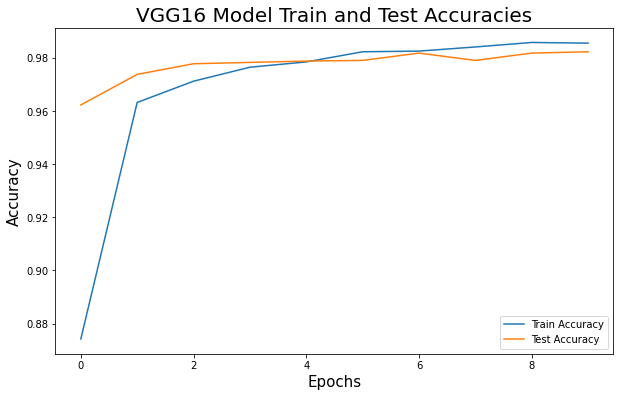

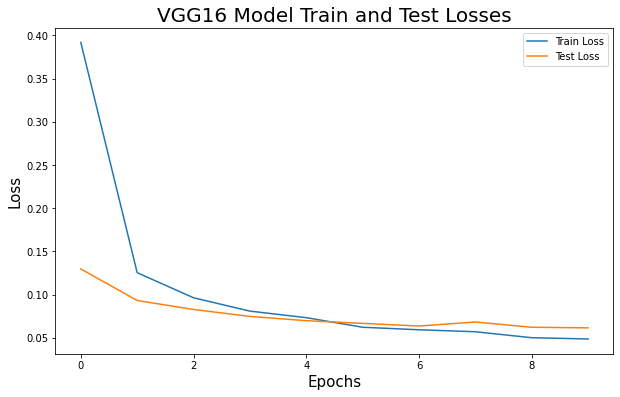

In [ ]:
EPOCHS = 10

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, EPOCHS), history2.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, EPOCHS), history2.history["val_accuracy"], label="Test Accuracy")
plt.title("VGG16 Model Train and Test Accuracies", fontsize = 20)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, EPOCHS), history2.history["loss"], label="Train Loss")
plt.plot(np.arange(0, EPOCHS), history2.history["val_loss"], label="Test Loss")
plt.title("VGG16 Model Train and Test Losses", fontsize = 20)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend(loc="upper right")
plt.show()


In [ ]:
# Evaluate model on test data.
vgg_score = vgg_model_final.evaluate(X_test,
                               y_test,
                               verbose=1)

vgg_labels = vgg_model_final.metrics_names

125/125 [==============================] - 39s 309ms/step - loss: 0.0615 - accuracy: 0.9822


In [ ]:
print(f'CNN {vgg_labels[0]}  : {vgg_score[0]}')
print(f'CNN {vgg_labels[1]}   : {vgg_score[1]}')

CNN loss  : 0.06147142872214317
CNN accuracy   : 0.9822499752044678


Using just 10 epochs, it achieved an accuracy of 98.2%.

In [ ]:
Y_pred = vgg_model_final.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       995
           1       0.98      0.98      0.98      1024
           2       0.98      0.99      0.98      1004
           3       0.98      0.97      0.97       977

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



**VGG Layer Visualizations**

In [ ]:
for layer in vgg_model_final.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


In [ ]:
layer_outputs = [layer.output for layer in vgg_model_final.layers if 'conv' in layer.name]
activation_model = Model(inputs=vgg_model_final.input, outputs=layer_outputs)
activations = activation_model.predict(images[55].reshape(1,image_size,image_size,3))

In [ ]:
len(activations)

13

A random image product is chosen for examining the CNN visualization.

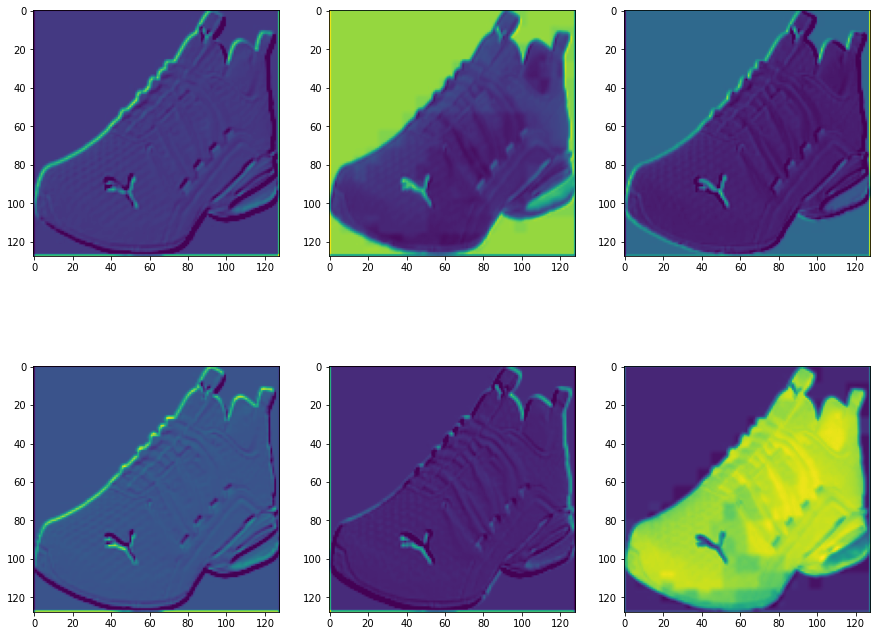

In [ ]:
activation = activations[0]
idx=0
row_size = 2
col_size = 3
fig, ax = plt.subplots(row_size, col_size, figsize=(15,12))
for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, idx]) #,cmap='gray')
            idx += 1

As specified in the convulational architecture of VGG16, the initial layers identify low level features such as outlines. We can clearly observe that the image in question, a sports sneaker analyzed on it's general shape from a normal view.

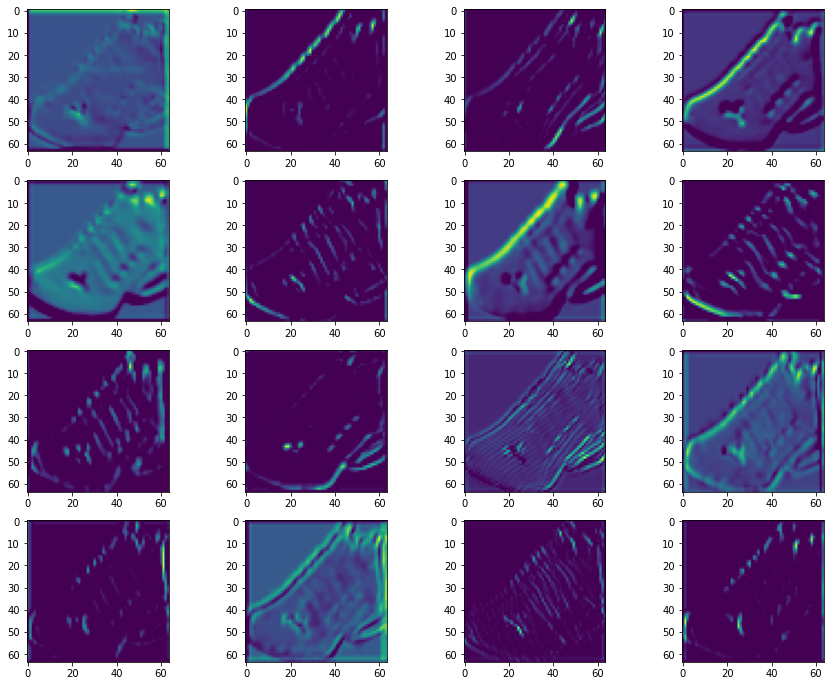

In [ ]:
activation = activations[3]
idx=0
row_size = 4
col_size = 4
fig, ax = plt.subplots(row_size, col_size, figsize=(15,12))
for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, idx])
            idx += 1

The intermediate convulational blocks start to zoom into more distinct surface features such as the ones observed above, where the texture and patterns seem to be analyzed.

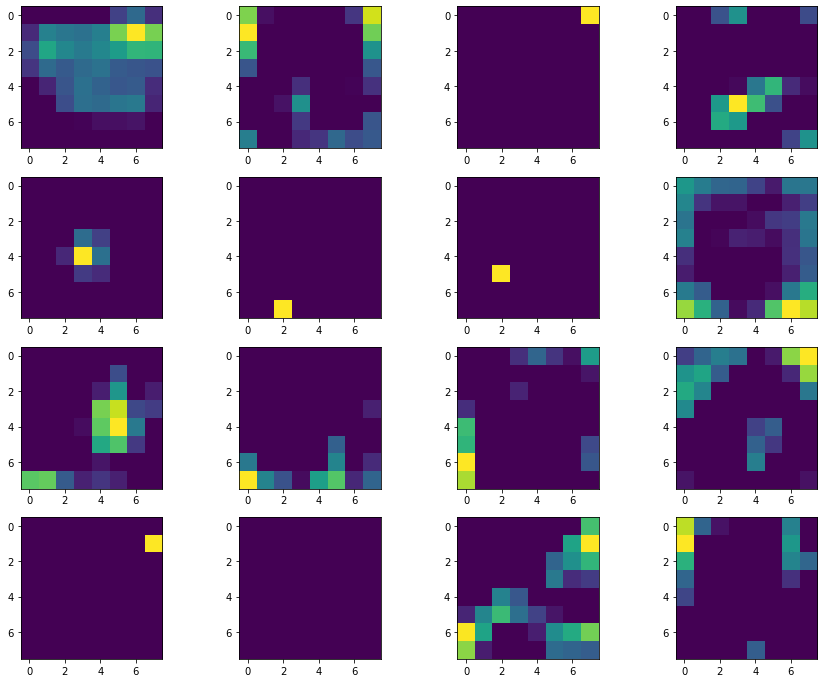

In [ ]:
activation = activations[11]
idx=0
row_size = 4
col_size = 4
fig, ax = plt.subplots(row_size, col_size, figsize=(15,12))
for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, idx])
            idx += 1

Towards the final layers, after several convulations and pooling, the features start to become less distinct.

**Compare Both Model Perfomance**

In [ ]:
# Compare models.
print(f'Customized {cnn_labels[1]}  : {cnn_score[1]}')
print(f'VGG {vgg_labels[1]}   : {vgg_score[1]}')
print()

Customized CNN accuracy  : 0.9679999947547913
VGG accuracy   : 0.9822499752044678



Not only did the customized model perform better than the baseline, it even came within 2 percentage point accuracy of the VGG-16 ImageNet Model. This is a very good performance with respect only to the limits of these moderately sized dataset.

## **4. Conclusions & Recommendations**

Using a neural network of just 2 convolutional blocks and a dense node, the custom model was able to execute with extremely good accuracy of approximately 96% for product classification after using 50 epochs of gradual training. The high accuracy could also have been partially boosted using the the augmentation generator and regularization techniques. In comparison, the performance of the custom model came within 3 percentage points of the reknown VGG-16 pre-trained model which had a 98% accuracy.

It can be presumed that the high accuracy was partially due also to the metrics set out which was not overly abstract and also due to the consistency and purity of the base data images, which were mostly standard in each class without much variation or mislabelling. If the problem statement requirements were not demanding, a densely layered network was not necessary and a more lean model would meet the requirements quite sufficiently.

However, in detecting more granular details, a qualitiative assessment shows that the network was still not very good in distinguishing more detailed patterns. This could also be due to the fact that product surface designs are mostly unique such as shirt and bag imprints. The model limited by the richness of the underlying data would be unable to make this distinction very well due to the lack of enough image volume to combat this unique feature inbalance.

Future recommendations to help improve on this scope would be to add more complicated product images into the mix, such as toys or jewelry, which typically do not have homogenous features and can be quite challenging to perform feature recognition on. Also, segregation within classes itself, like splitting gender related items can also be another option to explore. 

Another step that could be done at the same time would be to experiment with slicing and modifying the VGG-16 model to create a hybrid structure capable of more powerful visual analysis.

### **References**

https://arxiv.org/pdf/1409.1556.pdf

http://cs231n.stanford.edu/reports/2017/pdfs/105.pdf